# <span style="color:teal">Plant </span><span style="color:green">*Seedlings*</span><span style="color:teal"> Classification</span>
***



#### Initialization

In [1]:
#importing libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from keras.preprocessing import image

from sklearn.model_selection import train_test_split
import itertools

from keras.utils.np_utils import to_categorical

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Load Data

In [2]:
train_dir = '../input/plant-seedlings-classification/train'
test_dir = '../input/plant-seedlings-classification/test'
sample_submission = pd.read_csv('../input/plant-seedlings-classification/sample_submission.csv')


#### Different Species

In [3]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']

for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))
    

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


#### Training Data Files

In [4]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['../input/plant-seedlings-classification/train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)


Training Data:  (4750, 3)


#### Image Pre-processing

In [5]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp


#### Loading Traing Data

In [19]:
%%time

x_train = []

for i in range(len(train)):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(64,64))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(64,64,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

CPU times: user 37 s, sys: 1.85 s, total: 38.8 s
Wall time: 43.4 s


In [20]:
x_train.shape

(4750, 64, 64, 4)

#### Sample Images

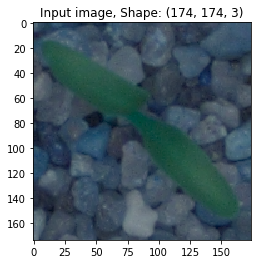

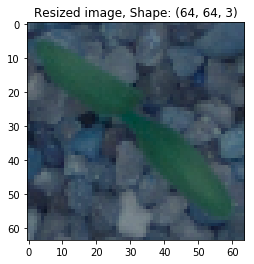

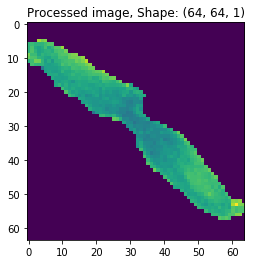

In [12]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(64,64)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()


In [21]:
# Reshape the Data array from 4D to 2D. 
print("the shape of x_train:", x_train.shape)
x_train_2d = np.reshape(x_train,(4750,64*64*4))  
# or: x_train_2d_b = np.reshape(x_train,(60,-1))    #-1 means unspecified

x_train_2d

the shape of x_train: (4750, 64, 64, 4)


array([[ 81,  96, 110, ...,  74,  77,   0],
       [ 58,  66,  77, ..., 163, 165,   0],
       [ 31,  52,  77, ...,  30,  48,   0],
       ...,
       [ 24,  51,  76, ...,  69,  92,   0],
       [ 74,  70,  81, ...,  60,  70,   0],
       [ 74,  97, 113, ...,  73,  89,   0]], dtype=uint8)

#### One-hot Encoding

In [22]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))


#### CV-Partition

In [23]:
x_train, x_val, y_train, y_val = train_test_split(x_train_2d, labels, test_size = 0.1, random_state=10)


In [24]:
x_train.shape

(4275, 16384)

In [26]:
y_train.shape

(4275, 12)

#### Input Shape

In [27]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)


Input Shape is : (16384,)


***
## <span style="color:teal">Applying Suppot Vector Machine</span>
***

#### Applying SVM

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(x_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


#### Prediction Score [Training Features]

In [29]:
svm.score(x_train,np.argmax(y_train,axis=1))

1.0

#### Prediction Score [Validation Features]

In [30]:
svm.score(x_val,np.argmax(y_val,axis=1))


0.13052631578947368